# Supervised Learning
### Setting imports

In [1]:
%matplotlib inline
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import svm
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn import svm # SVM classifier
from sklearn.neural_network import MLPClassifier # MLP classifier
from sklearn import cross_validation # used to test classifier
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve # ROC Curves
from sklearn.metrics import auc # Calculating AUC for ROC's!

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Read data from csv file.

In [2]:
original = pd.read_csv('clean_data_new.csv')
original.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,if_popular
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,1
1,300000000,285,139.082615,961000000,169.0,6.9,4500,0
2,245000000,206647,107.376788,880674609,148.0,6.3,4466,0
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106,1
4,260000000,49529,43.926995,284139100,132.0,6.1,2124,0


### Drop coloum that would not be used.

In [13]:
data_valid = original.drop(['id','runtime','vote_count'],axis=1)
data_valid.head()

,budget,popularity,revenue,vote_average,if_popular
0,237000000,150.437577,2787965087,7.2,1
1,300000000,139.082615,961000000,6.9,0
2,245000000,107.376788,880674609,6.3,0
3,250000000,112.312950,1084939099,7.6,1
4,260000000,43.926995,284139100,6.1,0


## Supervised Learning

### Data scaling function to make data to [0,1]

In [14]:
def scaled_df(df):
    scaled = pd.DataFrame()
    for item in df:
        if item in df.select_dtypes(include=[np.float]):
            scaled[item] = ((df[item] - df[item].min()) / 
            (df[item].max() - df[item].min()))
        else: 
            scaled[item] = df[item]
    return scaled

data_valid_scaled = scaled_df(data_valid)

### Getting box plot

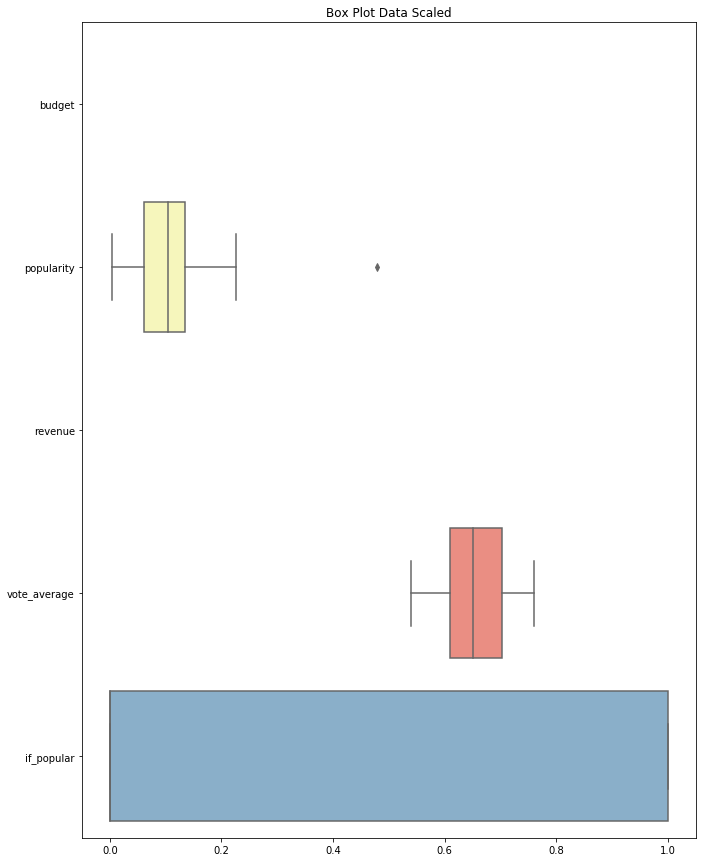

In [15]:
f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#FFFFFF')
plt.title("Box Plot Data Scaled")
ax.set(xlim=(-.05, 1.05))
ax = sns.boxplot(data = data_valid_scaled[0:40], 
  orient = 'h', 
  palette = 'Set3')

## Decision Tree

### rank_predictor function to predict the relationship of each factor

In [18]:
data_names=['budget','popularity','revenue']

def rank_predictors(dat,l,f='if_popular'):
    rank={}
    max_vals=dat.max()
    median_vals=dat.groupby(f).median()  # We are using the median as the mean is sensitive to outliers
    for p in l:
        score=np.abs((median_vals[p][0]-median_vals[p][1])/max_vals[p])
        rank[p]=score
    return rank

cat_rank = rank_predictors(data_valid,data_names)
cat_rank

{'budget': 0.006578947368421052,
 'popularity': 0.016576882600297185,
 'revenue': 0.008441045624901687}

In [19]:
cat_rank=sorted(cat_rank.items(), key=lambda x: x[1])
cat_rank

[('budget', 0.006578947368421052),
 ('revenue', 0.008441045624901687),
 ('popularity', 0.016576882600297185)]

### Take the top predictors based on median difference

In [20]:
# Take the top predictors based on median difference
ranked_predictors=[]
for f in cat_rank[0:]:
    ranked_predictors.append(f[0])
ranked_predictors

['budget', 'revenue', 'popularity']

### Setting X, y values

In [21]:
X = data_valid_scaled[data_names]
#setting target
y = data_valid_scaled['if_popular']

### Import library that we use.

In [22]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


### Do first time of decision tree.

In [23]:
#dividing data to have a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [24]:
# Decision Tree classifier

DTm = DecisionTreeClassifier()
                                
# Decision Tree cross validation

print("KfoldCrossVal mean score using Decision Tree is %s" %cross_val_score(DTm,X,y,cv=10).mean())

# Decision Tree metrics
sm = DTm.fit(X_train, y_train)

y_pred = sm.predict(X_test)
print("Accuracy score using Decision Tree is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using Decision Tree is 0.6839457121124657
Accuracy score using Decision Tree is 0.7127991675338189


### Optimize the model, changing parameters.

In [25]:
regressor = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth': range(1, 6),
             'random_state':range(0,5,1),
             'min_samples_split':range(2,5,1),
             'min_samples_leaf':range(1,5,1)}
scoring_fnc = make_scorer(accuracy_score)
kfold = KFold(n_splits=10)
grid = GridSearchCV(regressor, parameters, scoring_fnc, cv=kfold)
grid = grid.fit(X_train, y_train)
reg = grid.best_estimator_
print('best score: %f'%grid.best_score_)
print('best parameters:')
for key in parameters.keys():
    print('%s: %d'%(key, reg.get_params()[key]))
print('test score: %f'%reg.score(X_test, y_test))
import pandas as pd
pd.DataFrame(grid.cv_results_).T

best score: 0.805830
best parameters:
max_depth: 5
random_state: 0
min_samples_split: 2
min_samples_leaf: 2
test score: 0.812695


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
mean_fit_time,0.00269182,0.00267658,0.00244989,0.00189514,0.00183947,0.00199859,0.00184045,0.00197375,0.00188541,0.00192728,...,0.00391366,0.00415246,0.00449007,0.00439208,0.00457907,0.00420067,0.00430996,0.00404508,0.00448289,0.00446613
std_fit_time,0.000364063,0.000324084,0.000534176,0.00010949,8.38813e-05,0.000316918,0.000211393,0.000181008,0.000102218,0.000206005,...,0.000102401,0.000627474,0.000595679,0.000368555,0.000396403,0.000112476,0.000454021,0.000146103,0.000379561,0.000544135
mean_score_time,0.000463486,0.000507522,0.000444818,0.000348878,0.000311828,0.000343466,0.000322723,0.000348616,0.000346208,0.000328469,...,0.000282979,0.000310469,0.000360441,0.000346994,0.000411749,0.000364709,0.000337696,0.000338244,0.000348926,0.000390577
std_score_time,5.74952e-05,0.000110236,0.000141695,0.000110842,2.65523e-05,5.77335e-05,8.24975e-05,9.74074e-05,7.22167e-05,4.17955e-05,...,5.59187e-06,5.88159e-05,5.94118e-05,5.77928e-05,7.95365e-05,6.31219e-05,4.96951e-05,9.14107e-05,4.82851e-05,6.90781e-05
param_max_depth,1,1,1,1,1,1,1,1,1,1,...,5,5,5,5,5,5,5,5,5,5
param_min_samples_leaf,1,1,1,1,1,1,1,1,1,1,...,4,4,4,4,4,4,4,4,4,4
param_min_samples_split,2,2,2,2,2,3,3,3,3,3,...,3,3,3,3,3,4,4,4,4,4
param_random_state,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
params,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...","{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...",...,"{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 4, 'min_s..."
split0_test_score,0.779221,0.779221,0.779221,0.779221,0.779221,0.779221,0.779221,0.779221,0.779221,0.779221,...,0.794805,0.794805,0.794805,0.794805,0.794805,0.794805,0.794805,0.794805,0.794805,0.794805


### Put best parameters into model.

In [26]:
# Decision Tree classifier

DTm = DecisionTreeClassifier(max_depth=5,random_state=0,min_samples_split=2,min_samples_leaf=2)
                                
# Decision Tree cross validation

print("KfoldCrossVal mean score using Decision Tree is %s" %cross_val_score(DTm,X,y,cv=10).mean())

# Decision Tree metrics
sm = DTm.fit(X_train, y_train)

y_pred = sm.predict(X_test)
print("Accuracy score using Decision Tree is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using Decision Tree is 0.7888778542875621
Accuracy score using Decision Tree is 0.8126951092611863


## Random Forest

### Setting parameters of model and get result.

In [27]:
# Random Forest classifier

RFm = RandomForestClassifier( random_state = 42,
                                criterion='gini',
                                n_estimators = 50)
                                
# Random Forest cross validation

print("KfoldCrossVal mean score using Random Forest is %s" %cross_val_score(RFm,X,y,cv=10).mean())

# Random Forest metrics
sm = RFm.fit(X_train, y_train)

y_pred = sm.predict(X_test)
print("Accuracy score using Random Forest is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using Random Forest is 0.7447197814081947
Accuracy score using Random Forest is 0.8033298647242456


### Optimize the model, changing parameters.

In [28]:
regressor = RandomForestClassifier()
parameters = {'n_estimators': range(10,50,10),
             'random_state':range(20,50,10),
             'min_samples_split':range(2,5,1),
             'min_samples_leaf':range(1,5,1)}
scoring_fnc = make_scorer(accuracy_score)
kfold = KFold(n_splits=10)
grid = GridSearchCV(regressor, parameters, scoring_fnc, cv=kfold)
grid = grid.fit(X_train, y_train)
reg = grid.best_estimator_
print('best score: %f'%grid.best_score_)
print('best parameters:')
for key in parameters.keys():
    print('%s: %d'%(key, reg.get_params()[key]))
print('test score: %f'%reg.score(X_test, y_test))
import pandas as pd
pd.DataFrame(grid.cv_results_).T

best score: 0.812337
best parameters:
n_estimators: 40
random_state: 20
min_samples_split: 2
min_samples_leaf: 3
test score: 0.823101


,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
mean_fit_time,0.0309701,0.031531,0.0287947,0.0528247,0.052577,0.0521331,0.0773946,0.0776932,0.0781986,0.106284,...,0.0260645,0.0495703,0.0500573,0.0457714,0.0691282,0.0700913,0.0727198,0.0957491,0.0989571,0.1031
std_fit_time,0.00580384,0.00253112,0.00205047,0.00248674,0.00219606,0.00149442,0.00285392,0.00384726,0.00387756,0.00496589,...,0.00233875,0.00313913,0.00328104,0.00286153,0.00379257,0.00354585,0.0046948,0.00268267,0.00531711,0.00386537
mean_score_time,0.0014282,0.00159543,0.00140548,0.00216939,0.00230217,0.00222566,0.00312216,0.00316961,0.0031024,0.00407419,...,0.0012938,0.00200539,0.00233867,0.0019917,0.0026834,0.00276084,0.00285397,0.00369754,0.00398726,0.00409796
std_score_time,0.000238473,0.000179451,0.000247281,0.000200595,0.000567275,0.000224567,0.000283413,0.000485511,0.000288226,0.000239228,...,0.000185049,0.000108327,0.000365044,0.000240221,0.000119122,0.000144278,0.000160685,0.00031623,0.000728094,0.000237644
param_min_samples_leaf,1,1,1,1,1,1,1,1,1,1,...,4,4,4,4,4,4,4,4,4,4
param_min_samples_split,2,2,2,2,2,2,2,2,2,2,...,4,4,4,4,4,4,4,4,4,4
param_n_estimators,10,10,10,20,20,20,30,30,30,40,...,10,20,20,20,30,30,30,40,40,40
param_random_state,20,30,40,20,30,40,20,30,40,20,...,40,20,30,40,20,30,40,20,30,40
params,"{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...","{'min_samples_leaf': 1, 'min_samples_split': 2...",...,"{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4...","{'min_samples_leaf': 4, 'min_samples_split': 4..."
split0_test_score,0.750649,0.755844,0.758442,0.761039,0.758442,0.768831,0.761039,0.768831,0.763636,0.774026,...,0.787013,0.797403,0.794805,0.794805,0.792208,0.792208,0.8,0.794805,0.8,0.8


### Put best parameters into model.

In [29]:
# Random Forest classifier

RFm = RandomForestClassifier( random_state = 20,
                                criterion='gini',
                                n_estimators = 40,
                                min_samples_split = 2,
                                min_samples_leaf = 3)
                                
# Random Forest cross validation

print("KfoldCrossVal mean score using Random Forest is %s" %cross_val_score(RFm,X,y,cv=10).mean())

# Random Forest metrics
sm = RFm.fit(X_train, y_train)

y_pred = sm.predict(X_test)
print("Accuracy score using Random Forest is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using Random Forest is 0.7736751389256609
Accuracy score using Random Forest is 0.8231009365244537


## Conclusion
As for Decision Tree, its accuracy is 81.3%. As for Random Forest, its accuracy is 82.3%.

MIT License

Copyright (c) 2018 Bo Cao

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.